In [2]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("seaborn")

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [41]:
n = 6
r_cutoff = 5
Rs = np.arange(1,n + 1) * r_cutoff / (n+1)


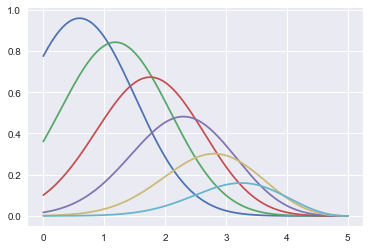

In [73]:
def symmetry_function(x, rs, eta=0.5):
    return np.exp(-eta*(x - rs)**2)

def cut_off(x, r_cutoff):
    
    L = x > r_cutoff
    
    out = 0.5 * (np.cos(np.pi * x / r_cutoff) + 1)
    
    try:
        # works only of out is non scalar
        out[x > r_cutoff] = 0
    except:
        if x > r_cutoff:
            out = 0
        
    return out

plt.figure()
x = np.linspace(0, r_cutoff, 200)

for rs in Rs:
    plt.plot(x, symmetry_function(x, rs) * cut_off(x, r_cutoff))
plt.show()


# Apply
- all funcitons weighted by  r cut-off function
- phi and theta just guassians
- phi from [0, 2Pi], theta [0,Pi]

In [100]:
n=6
R_s = np.arange(1,n + 1) * r_cutoff / (n+1)
PHI_s = np.arange(1,n + 1) * 2 * np.pi / (n+1)
THETA_s = np.arange(1,n + 1) * np.pi / (n+1)

R_cutoff = 10

def spherical_coordinates(x):
    r = np.sqrt(np.sum(x**2))
    phi = np.arctan2(x, x[0])[0]
    theta = np.arccos(x[2] / r)
    
    return r, phi, theta
    

def atomic_descriptors(R):
    """R... direction atom i to atom j"""
    r, phi, theta = spherical_coordinates(R)
    G = []
    
    for r_s in R_s:
        G.append(symmetry_function(r, r_s) * cut_off(r, R_cutoff))

    for phi_s in PHI_s:
        G.append(symmetry_function(phi, phi_s) * cut_off(r, R_cutoff))

    for theta_s in THETA_s:
        G.append(symmetry_function(theta, theta_s) * cut_off(r, R_cutoff))

        
    return G
    
                
        
                                                                                        
def calculate_descriptor(molecule_geometry):
    
    descriptor_molecule = []
    
    for i, geom_i in enumerate(molecule_geometry):
        
        descriptor_atom = np.zeros(3 * n)
        
        for j, geom_j in enumerate(molecule_geometry):
            if i == j:
                continue
            
            descriptor_atom += np.array(atomic_descriptors(geom_i - geom_j))
            
        descriptor_molecule.append(descriptor_atom)
    return descriptor_molecule

# Actual molecule 

In [155]:
molecules = np.load("../data/molecules400.npy")
S = np.load("../data/S400.npy")
P = np.load("../data/P400.npy")

dim = 26
dim_in = 10 * 18
dim_triu = int(26 * 27 / 2)

676

In [104]:
descriptors = np.array([calculate_descriptor(np.array(mol.positions)) for mol in molecules])

In [109]:
descriptors = descriptors.reshape(603, -1)

In [156]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset, extract_triu

dataset, molecules = make_butadien_dataset(
    molecules,
    descriptors,
    np.array(list(map(lambda x: extract_triu(x, dim), P))),
    test_samples=100
)

[-] 2018-06-17 21:45:41: Data set normalized. Mean value std: 0.45451653863945896


In [146]:
from SCFInitialGuess.nn.training import Trainer
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.cost_functions import RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim_in,  dim_triu * 2, dim_triu + 100, dim_triu]),
    cost_function=RegularizedMSE(alpha=1e-7),
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3)
)

trainer.setup()

network, sess = trainer.train(
    dataset,
    convergence_threshold=5e-7
)

[-] 2018-06-17 21:41:36: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-06-17 21:41:36: Setting up the training in the target graph ...
[-] 2018-06-17 21:41:36: network ...
[-] 2018-06-17 21:41:36: error function ...
[-] 2018-06-17 21:41:36: cost function ...
[-] 2018-06-17 21:41:36: training step
[-] 2018-06-17 21:41:37: Starting network training ...
[ ] 2018-06-17 21:41:37: Val. Cost: 9.489E-02. Error: 9.489E-02. Diff: 1.0E+10
[ ] 2018-06-17 21:41:38: Val. Cost: 1.136E-04. Error: 1.105E-04. Diff: 9.5E-02
[ ] 2018-06-17 21:41:39: Val. Cost: 2.262E-04. Error: 2.229E-04. Diff: 1.1E-04
[ ] 2018-06-17 21:41:41: Val. Cost: 3.050E-05. Error: 2.716E-05. Diff: 2.0E-04
[ ] 2018-06-17 21:41:42: Val. Cost: 1.876E-05. Error: 1.538E-05. Diff: 1.2E-05
[ ] 2018-06-17 21:41:44: Val. Cost: 1.977E-05. Error: 1.634E-05. Diff: 9.7E-07
[ ] 2018-06-17 21:41:45: Val. Cost: 1.770E-05. Error: 1.424E-05. Diff: 2.1E-06
[ ] 2018-06-17 21:41:46: Val. Cost: 1.273E-05. Error: 9.249E-06

In [147]:
with trainer.graph.as_default():
    p_nn = network.run(sess, dataset.testing[0])

## Analyze

In [148]:
from SCFInitialGuess.utilities.analysis import measure_absolute_error, statistics
statistics(measure_absolute_error(p_nn, dataset))

(0.001685755558871004, 0.0002400742069830684)

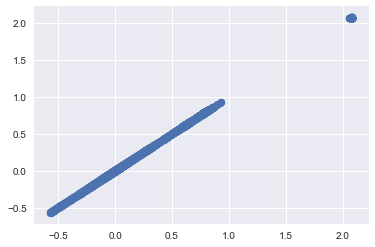

In [149]:
plt.scatter(p_nn.flatten(), dataset.testing[1].flatten())

In [153]:
np.array(list(map(lambda x: reconstruct_from_triu(x, dim), p_nn))).reshape(-1, dim, dim).shape

(100, 26, 26)

In [157]:
from SCFInitialGuess.utilities.analysis import measure_iterations, mf_initializer
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

iterations = measure_iterations(
    mf_initializer, 
    np.array(list(map(lambda x: reconstruct_from_triu(x, dim), p_nn))).reshape(-1, dim, dim).astype("float64"), 
    molecules[1]
)

statistics(iterations)

[ ] 2018-06-17 21:45:49: Iteration calculation: 0
[ ] 2018-06-17 21:45:49: Iteration calculation: 1
[ ] 2018-06-17 21:45:49: Iteration calculation: 2
[ ] 2018-06-17 21:45:50: Iteration calculation: 3
[ ] 2018-06-17 21:45:50: Iteration calculation: 4
[ ] 2018-06-17 21:45:50: Iteration calculation: 5
[ ] 2018-06-17 21:45:51: Iteration calculation: 6
[ ] 2018-06-17 21:45:51: Iteration calculation: 7
[ ] 2018-06-17 21:45:51: Iteration calculation: 8
[ ] 2018-06-17 21:45:51: Iteration calculation: 9
[ ] 2018-06-17 21:45:52: Iteration calculation: 10
[ ] 2018-06-17 21:45:52: Iteration calculation: 11
[ ] 2018-06-17 21:45:52: Iteration calculation: 12
[ ] 2018-06-17 21:45:53: Iteration calculation: 13
[ ] 2018-06-17 21:45:53: Iteration calculation: 14
[ ] 2018-06-17 21:45:53: Iteration calculation: 15
[ ] 2018-06-17 21:45:53: Iteration calculation: 16
[ ] 2018-06-17 21:45:54: Iteration calculation: 17
[ ] 2018-06-17 21:45:54: Iteration calculation: 18
[ ] 2018-06-17 21:45:54: Iteration calcul

(11.24, 1.980504986108341)

#  Electronegativity weighted

In [139]:
from SCFInitialGuess.utilities.constants import electronegativities as CHI

def calculate_descriptor_chi(molecule_geometry):
    
    descriptor_molecule = []
    
    for i, geom_i in enumerate(molecule_geometry):
        
        descriptor_atom = np.zeros(3 * n)
        
        for j, geom_j in enumerate(molecule_geometry):
            if i == j:
                continue
            
            descriptor_atom += CHI[geom_j[0]] *  np.array(atomic_descriptors(
                np.array(geom_i[1]) - np.array(geom_j[1])))
            
        descriptor_molecule.append(descriptor_atom)
    return descriptor_molecule

In [140]:
molecules = np.load("../data/molecules400.npy")
descriptors_chi = np.array([calculate_descriptor_chi(list(mol.geometry)) for mol in molecules])

In [158]:
descriptors_chi = descriptors_chi.reshape(603, -1)

In [159]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset, extract_triu

molecules = np.load("../data/molecules400.npy")

dataset_chi, molecules = make_butadien_dataset(
    molecules,
    descriptors_chi,
    np.array(list(map(lambda x: extract_triu(x, dim), P))),
    test_samples=100
)

[-] 2018-06-17 21:48:15: Data set normalized. Mean value std: 1.0650301655318755


In [161]:
from SCFInitialGuess.nn.training import Trainer
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.cost_functions import RegularizedMSE

trainer_chi = Trainer(
    EluTrNNN([dim_in,  dim_triu * 2, dim_triu + 100, dim_triu]),
    cost_function=RegularizedMSE(alpha=1e-7),
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3)
)

trainer_chi.setup()

network_chi, sess_chi = trainer_chi.train(
    dataset_chi,
    convergence_threshold=5e-7
)

[-] 2018-06-17 21:51:02: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-06-17 21:51:02: Setting up the training in the target graph ...
[-] 2018-06-17 21:51:02: network ...
[-] 2018-06-17 21:51:02: error function ...
[-] 2018-06-17 21:51:02: cost function ...
[-] 2018-06-17 21:51:02: training step
[-] 2018-06-17 21:51:02: Starting network training ...
[ ] 2018-06-17 21:51:02: Val. Cost: 9.450E-02. Error: 9.450E-02. Diff: 1.0E+10
[ ] 2018-06-17 21:51:04: Val. Cost: 1.093E-04. Error: 1.063E-04. Diff: 9.4E-02
[ ] 2018-06-17 21:51:05: Val. Cost: 5.438E-05. Error: 5.119E-05. Diff: 5.5E-05
[ ] 2018-06-17 21:51:06: Val. Cost: 2.917E-05. Error: 2.587E-05. Diff: 2.5E-05
[ ] 2018-06-17 21:51:08: Val. Cost: 2.735E-05. Error: 2.400E-05. Diff: 1.9E-06
[ ] 2018-06-17 21:51:09: Val. Cost: 3.859E-05. Error: 3.520E-05. Diff: 1.1E-05
[ ] 2018-06-17 21:51:11: Val. Cost: 1.478E-04. Error: 1.444E-04. Diff: 1.1E-04
[ ] 2018-06-17 21:51:12: Val. Cost: 1.592E-05. Error: 1.247E-05

In [167]:
with trainer.graph.as_default():
    p_nn_chi = network_chi.run(sess_chi, dataset_chi.testing[0])

## Chi analysis

In [168]:
from SCFInitialGuess.utilities.analysis import measure_absolute_error, statistics
print(statistics(measure_absolute_error(p_nn_chi, dataset)))


(0.0010718902050180338, 0.00022717385773239255)


In [169]:

from SCFInitialGuess.utilities.analysis import measure_iterations, mf_initializer
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

iterations = measure_iterations(
    mf_initializer, 
    np.array(list(map(lambda x: reconstruct_from_triu(x, dim), p_nn_chi))).reshape(-1, dim, dim).astype("float64"), 
    molecules[1]
)

statistics(iterations)

[ ] 2018-06-17 21:55:55: Iteration calculation: 0
[ ] 2018-06-17 21:55:55: Iteration calculation: 1
[ ] 2018-06-17 21:55:55: Iteration calculation: 2
[ ] 2018-06-17 21:55:55: Iteration calculation: 3
[ ] 2018-06-17 21:55:56: Iteration calculation: 4
[ ] 2018-06-17 21:55:56: Iteration calculation: 5
[ ] 2018-06-17 21:55:56: Iteration calculation: 6
[ ] 2018-06-17 21:55:56: Iteration calculation: 7
[ ] 2018-06-17 21:55:57: Iteration calculation: 8
[ ] 2018-06-17 21:55:57: Iteration calculation: 9
[ ] 2018-06-17 21:55:57: Iteration calculation: 10
[ ] 2018-06-17 21:55:57: Iteration calculation: 11
[ ] 2018-06-17 21:55:58: Iteration calculation: 12
[ ] 2018-06-17 21:55:58: Iteration calculation: 13
[ ] 2018-06-17 21:55:58: Iteration calculation: 14
[ ] 2018-06-17 21:55:59: Iteration calculation: 15
[ ] 2018-06-17 21:55:59: Iteration calculation: 16
[ ] 2018-06-17 21:55:59: Iteration calculation: 17
[ ] 2018-06-17 21:55:59: Iteration calculation: 18
[ ] 2018-06-17 21:56:00: Iteration calcul

(9.88, 1.3731715115017498)

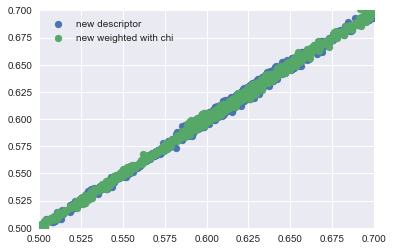

In [175]:
lower, upper = 0.5, 0.7

plt.scatter(p_nn.flatten(), dataset.testing[1].flatten(), label="new descriptor")
plt.scatter(p_nn_chi.flatten(), dataset.testing[1].flatten(), label="new weighted with chi")
plt.legend()


plt.xlim([lower, upper])
plt.ylim([lower, upper])

plt.show()
